# Reinforcement Learning – Project 3 – Sam Linderoth


*Acknowledgement: I have used an LLM to generate code for the plots. The problem implementation and solutions have, however, been done by me personally.*

# Manual calculations

## Problem 1

According to the definition of updating, we have

$$
\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_{t} + \alpha \delta_{t, v} \nabla_{\boldsymbol{\theta}} \hat{v} (s ; \boldsymbol{\theta}_t).
$$

Now,

$$
\nabla_{\boldsymbol{\theta}} \hat{v} (s ; \boldsymbol{\theta}) = \nabla_{\boldsymbol{\theta}} \boldsymbol{\theta}^{T} x(s).
$$

Since the weights are linear, we have $\frac{\partial}{\partial w_i} w_i = 1$ for all $w_i$, and hence


$$
\boldsymbol{\theta}_{t+1} = \boldsymbol{\theta}_{t} + \alpha \delta_{t, v} x(s).
$$

## Problem 2

First and foremost, we have that the derivative of $\log x$ is

$$
\frac{\partial}{\partial x} \log x = \frac{1}{x}.
$$

Furthermore, via the chain rule we have that

$$
\frac{\partial}{\partial x} f(g(x)) = f'(g(x))g'(x)
$$

and hence it follows, with $f(x) = \log x$ and $g(x) = \pi ( a \vert s ; \boldsymbol{\theta})$, that

$$
\frac{\nabla_{\boldsymbol{\theta}} \pi ( a \vert s ; \boldsymbol{\theta})}{\pi ( a \vert s ; \boldsymbol{\theta})} = \nabla_{\boldsymbol{\theta}} \log \pi ( a \vert s ; \boldsymbol{\theta}).
$$

Now, using the softmax policy, we have
$$
\begin{align*}
\nabla_{\boldsymbol{\theta}} \log \pi ( a \vert s ; \boldsymbol{\theta}) & = \nabla_{\boldsymbol{\theta}} \log \frac{e^{\boldsymbol{\theta}^{T}x(s, a)}}{\Sigma_{b} e^{\boldsymbol{\theta}^{T}x(s, b)}} \\
& = \nabla_{\boldsymbol{\theta}} (\log e^{\boldsymbol{\theta}^{T}x(s, a)} - \log \Sigma_{b} e^{\boldsymbol{\theta}^{T}x(s, b)} ) \\
& = \nabla_{\boldsymbol{\theta}} (\boldsymbol{\theta}^{T}x(s, a) - \log \Sigma_{b} e^{\boldsymbol{\theta}^{T}x(s, b)} ) \\
& =x(s, a) -  \nabla_{\boldsymbol{\theta}} \log \Sigma_{b} e^{\boldsymbol{\theta}^{T}x(s, b)}.
\end{align*}
$$

Now, using the chain rule again on the last term, we get

$$
\nabla_{\boldsymbol{\theta}} \log \pi ( a \vert s ; \boldsymbol{\theta}) = x(s, a) - \frac{\nabla_{\boldsymbol{\theta}} \Sigma_{b} e^{\boldsymbol{\theta}^{T}x(s, b)}}{\Sigma_{b} e^{\boldsymbol{\theta}^{T}x(s, b)}}.
$$

Since the gradient is taken with respect to $\boldsymbol{\theta}$ over a sum of exponentials, we get

$$
\begin{align*}
\nabla_{\boldsymbol{\theta}} \log \pi ( a \vert s ; \boldsymbol{\theta}) & = x(s, a) - \frac{x(s, b) \Sigma_{b} e^{\boldsymbol{\theta}^{T}x(s, b)}}{\Sigma_{b} e^{\boldsymbol{\theta}^{T}x(s, b)}} \\
& = x(s, a) -  \Sigma_{b} \frac{ e^{\boldsymbol{\theta}^{T}x(s, b)}}{\Sigma_{b} e^{\boldsymbol{\theta}^{T}x(s, b)}} x(s, b) \\
& = x(s, a) - \Sigma_{b} \pi(b \vert s ; \boldsymbol{\theta}) x(s, b).
\end{align*}
$$

Plugging this into the update formula (3) yields the result in question.

# Gridworld with Monster

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.ndimage import uniform_filter1d
import pandas as pd
from IPython.display import HTML

random.seed(900118)

def initialize_lists(size = 10):

  '''
  A function to initialize dicts/lists used in the code.
  '''

  # Weight vector
  weights = np.zeros(4)

  # Set grid
  grid = [(i, j) for i in range(size) for j in range(size)]

  # Reward storage
  episode_reward_storage = []

  return weights, grid, episode_reward_storage

def initialize_positions(grid):

  '''
  A function to initialize positions for the agent, monster and apple.
  '''

  grid_copy = grid.copy()

  agent_state = random.choice(grid_copy)
  grid_copy.remove(agent_state)
  monster_state = random.choice(grid_copy)
  grid_copy.remove(monster_state)
  apple_state = random.choice(grid_copy)

  return agent_state, monster_state, apple_state

def respawn_apple(grid, agent_state, monster_state):

  '''
  Apple respawn function.
  '''

  apple_state = random.choice(grid)
  while apple_state == agent_state or apple_state == monster_state:
    apple_state = random.choice(grid)

  return apple_state

def choose_action(Q, state, eps = 0.1):

  '''
  A function to choose actions, eps-greedy for tabular methods.
  '''

  if random.random() < eps:
    return random.choice(list(Q[state].keys()))
  else:
    return max(Q[state], key=Q[state].get)

def choose_action_greedy_grad(state, weights, actions, eps = 0.1):

    if random.random() < eps:
        return random.choice(actions)
    else:
        q_values = np.array([np.dot(weights, feature_fetch(state, a)) for a in actions])
        exp_q_values = np.exp((q_values - np.max(q_values)))
        probabilities = exp_q_values / np.sum(exp_q_values)

        # For exploitation, choose the highest probability action
        # This is not really true softmax
        return actions[np.argmax(probabilities)]

def choose_action_softmax(state, weights, actions, action_choice = True):

      q_values = []
      for a in actions:
          feat = feature_fetch(state, a)
          q_values.append(np.dot(weights, feat))

      q_values = np.array(q_values)

      exp_q_values = np.exp((q_values - np.max(q_values)))
      probabilities = exp_q_values / np.sum(exp_q_values)

      if action_choice:
        return np.random.choice(actions, p=probabilities)
      else:
        return probabilities

def feature_fetch(state, action):

    '''
    Returns the feature vector for a given state and action.
    '''

    agent_state, monster_state, apple_state = state

    # Calculate current distances
    current_dist_to_apple = abs(apple_state[0] - agent_state[0]) + abs(apple_state[1] - agent_state[1])
    current_dist_to_monster = abs(monster_state[0] - agent_state[0]) + abs(monster_state[1] - agent_state[1])

    # Calculate new agent position after taking the action
    new_agent_state = list(agent_state)
    if action == 'left':
        new_agent_state[0] -= 1
    elif action == 'right':
        new_agent_state[0] += 1
    elif action == 'up':
        new_agent_state[1] += 1
    elif action == 'down':
        new_agent_state[1] -= 1

    # Calculate new distances after taking the action
    new_dist_to_apple = abs(apple_state[0] - new_agent_state[0]) + abs(apple_state[1] - new_agent_state[1])
    new_dist_to_monster = abs(monster_state[0] - new_agent_state[0]) + abs(monster_state[1] - new_agent_state[1])

    # Feature 1: Inverse distance to apple
    f1 = 1 / (current_dist_to_apple + 1)

    # Feature 2: Inverse distance to monster
    f2 = 1 / (current_dist_to_monster + 1)

    # Feature 3: 1 if action takes you closer to apple, 0 otherwise
    f3 = 1 if new_dist_to_apple < current_dist_to_apple else 0

    # Feature 4: 1 if action takes you closer to monster, 0 otherwise
    f4 = 1 if new_dist_to_monster < current_dist_to_monster else 0

    return np.array([f1, f2, f3, f4], dtype=float)

def take_action(action, state, grid):

  '''
  A function take a chosen action.
  '''

  # Store original state
  original_state = state

  # Take action
  if action == 'left':
    state = (state[0] - 1, state[1])
  elif action == 'right':
    state = (state[0] + 1, state[1])
  elif action == 'up':
    state = (state[0], state[1] + 1)
  elif action == 'down':
    state = (state[0], state[1] - 1)

  if state not in grid:
    return original_state
  else:
    return state

def get_return(agent_former_state, agent_current_state, apple_state, monster_state):

  '''
  A function to fetch returns/rewards.
  '''

  if agent_current_state == apple_state and agent_current_state == monster_state:
    return -1 # Taking both apple and being caught, -1
  if agent_current_state == apple_state and agent_current_state != monster_state:
    return 1 # Taking apple
  if agent_current_state != apple_state and agent_current_state == monster_state:
    return -1 # Being caught by monster
  elif agent_former_state == agent_current_state:
    return 0 # Walking into a wall
  else:
    return 0 # Just walking

def n_step_sarsa(Q, n, grid, episode_reward_storage, actions,
                 alpha=0.01, gamma=0.95, eps=0.1, T=200):

    '''
    A function for n-step Sarsa algorithm, following the pseudocode on page 147 of Sutton & Barto.

    Inputs
    ---------
    Q: State-action dict
    n: Number of sarsa steps
    grid: The grid that the agent/monster/apple moves on
    episode_reward_storage: Reward storage
    actions: Action set (list)
    alpha: Learning rate (default: 0.01)
    gamma: Discount factor (default: 0.95)
    eps: Exploit/explore parameter (default: 0.1)
    T: Maximum steps (default: 200)

    Outputs
    ---------
    Q: Updated state-action dict
    episode_reward_storage: Updated reward storage
    '''

    # Initialize S
    agent_state, monster_state, apple_state = initialize_positions(grid)
    state = (agent_state, monster_state, apple_state)

    # Choose A from S using policy
    agent_action = choose_action(Q, state, eps=eps)

    # Store state and action
    local_states = [state]
    local_actions = [agent_action]
    local_rewards = []

    t = 0
    while True:
        if t < T:
            # Take action A, observe S', R
            agent_state = take_action(agent_action, agent_state, grid)
            monster_state = take_action(random.choice(actions), monster_state, grid)
            ret = get_return(local_states[-1][0], agent_state, apple_state, monster_state)
            if agent_state == apple_state:
                apple_state = respawn_apple(grid, agent_state, monster_state)
            new_state = (agent_state, monster_state, apple_state)

            # Store reward and next state
            local_rewards.append(ret)
            local_states.append(new_state)

            # If S' is terminal
            if agent_state == monster_state or t == T - 1:
                T = t + 1
            else:
                # Select and store and action A'
                agent_action = choose_action(Q, new_state, eps=eps)
                local_actions.append(agent_action)

        tau = t - n + 1 # tau is the time whose estimate is being updated
        if tau >= 0:
            G = sum([gamma**(i-tau) * local_rewards[i] for i in range(tau, min(tau+n, T))])
            if tau + n < T:
                G += gamma**n * Q[local_states[tau+n]][local_actions[tau+n]]
            Q[local_states[tau]][local_actions[tau]] += alpha * (G - Q[local_states[tau]][local_actions[tau]])

        # Until tau = T - 1
        if agent_state == monster_state or tau == T - 1:
            break

        # Update state,
        state = new_state

        # Add time
        t += 1

    # Summarize episode rewards
    episode_reward_storage.append(sum(local_rewards))

    return Q, episode_reward_storage

def n_step_grad_sarsa(weights, n, grid, episode_reward_storage, actions,
                 alpha=0.01, gamma=0.95, eps=0.1, T=200):

    '''
    A function for n-step semi-gradient Sarsa algorithm, following the pseudocode on page 247 of Sutton & Barto.

    Inputs
    ---------
    weights: Weight vector
    n: Number of sarsa steps
    grid: The grid that the agent/monster/apple moves on
    episode_reward_storage: Reward storage
    actions: Action set (list)
    alpha: Learning rate (default: 0.01)
    gamma: Discount factor (default: 0.95)
    eps: Exploit/explore parameter (default: 0.1)
    T: Maximum steps (default: 200)

    Outputs
    ---------
    weights: Updated weights
    episode_reward_storage: Updated reward storage
    '''

    # Initialize S
    agent_state, monster_state, apple_state = initialize_positions(grid)
    state = (agent_state, monster_state, apple_state)

    # Choose A from S using policy
    agent_action = choose_action_greedy_grad(state, weights, actions, eps = eps)

    # Store state and action
    local_states = [state]
    local_actions = [agent_action]
    local_rewards = []

    t = 0
    while True:
        if t < T:
            # Take action A, observe S', R
            agent_state = take_action(agent_action, agent_state, grid)
            monster_state = take_action(random.choice(actions), monster_state, grid)
            ret = get_return(local_states[-1][0], agent_state, apple_state, monster_state)
            if agent_state == apple_state:
                apple_state = respawn_apple(grid, agent_state, monster_state)
            new_state = (agent_state, monster_state, apple_state)

            # Store reward and next state
            local_rewards.append(ret)
            local_states.append(new_state)

            # If S' is terminal
            if agent_state == monster_state or t == T - 1:
                T = t + 1
            else:
                # Select and store and action A'
                agent_action = choose_action_greedy_grad(new_state, weights, actions, eps = eps)
                local_actions.append(agent_action)

        tau = t - n + 1 # tau is the time whose estimate is being updated
        if tau >= 0:
            G = sum([gamma**(i-tau) * local_rewards[i] for i in range(tau, min(tau+n, T))])
            if tau + n < T:
                G += gamma**n * np.dot(weights, feature_fetch(local_states[tau+n], local_actions[tau+n]))
            weights += alpha*(G - np.dot(weights, feature_fetch(local_states[tau], local_actions[tau])))*feature_fetch(local_states[tau], local_actions[tau])

        # Until tau = T - 1
        if agent_state == monster_state or tau == T - 1:
            break

        # Update state,
        state = new_state

        # Add time
        t += 1

    # Summarize episode rewards
    episode_reward_storage.append(sum(local_rewards))

    return weights, episode_reward_storage

def reinforce(weights, grid, episode_reward_storage, actions,
              alpha=0.01, gamma=0.95, T=200):

    '''
    A function for the REINFORCE algorithm, following the pseudocode on page 328 of Sutton & Barto.

    Inputs
    ---------
    weights: Weight vector
    grid: The grid that the agent/monster/apple moves on
    episode_reward_storage: Reward storage
    actions: Action set (list)
    alpha: Learning rate (default: 0.01)
    gamma: Discount factor (default: 0.95)
    eps: Exploit/explore parameter (default: 0.1)
    T: Maximum steps (default: 200)

    Outputs
    ---------
    weights: Updated weights
    episode_reward_storage: Updated reward storage
    '''

    # Initialize S
    agent_state, monster_state, apple_state = initialize_positions(grid)
    state = (agent_state, monster_state, apple_state)

    # Store states, actions, and rewards for the entire episode
    local_states = []
    local_actions = []
    local_rewards = []

    # Generate an episode following policy
    t = 0
    while t < T:
        # Choose action using current policy
        agent_action = choose_action_softmax(state, weights, actions)

        # Store state and action
        local_states.append(state)
        local_actions.append(agent_action)

        # Take action A, observe S', R
        agent_state = take_action(agent_action, agent_state, grid)
        monster_state = take_action(random.choice(actions), monster_state, grid)
        ret = get_return(local_states[-1][0], agent_state, apple_state, monster_state)
        if agent_state == apple_state:
            apple_state = respawn_apple(grid, agent_state, monster_state)
        new_state = (agent_state, monster_state, apple_state)

        # Store reward and next state
        local_rewards.append(ret)

        # Update state
        state = (agent_state, monster_state, apple_state)

        # Check if terminal state reached
        if agent_state == monster_state or t == T:
            break

        t += 1

    # Loop for each step of the episode
    for t in range(len(local_states)):
        # Calculate G
        G = sum([gamma**(k-t) * local_rewards[k] for k in range(t, len(local_rewards))])

        # Get the state and action at time t
        state_t = local_states[t]
        action_t = local_actions[t]

        # Calculate policy probabilities for all actions
        action_probs = choose_action_softmax(state_t, weights, actions, action_choice = False)

        # Setup feature vector
        feature_vector = feature_fetch(state_t, action_t)
        expected_features = np.zeros(len(feature_vector))

        # Sum_b pi(b | s, theta) x(s, b)
        for b in actions:
            expected_features += action_probs[actions.index(b)] * feature_fetch(state_t, b)

        # Calculate eligibility vector
        elig_vector = feature_vector - expected_features

        # Update the weights
        weights += alpha * gamma**t * G * elig_vector

    # Store total episode reward
    episode_reward_storage.append(sum(local_rewards))

    return weights, episode_reward_storage

def reinforce_baseline(policy_weights, statevalue_weights, grid, episode_reward_storage, actions,
                      policy_alpha=0.01, statevalue_alpha = 0.01, gamma=0.95, T=200):


    '''
    A function for the REINFORCE with baseline algorithm, following the pseudocode on page 330 of Sutton & Barto.

    Inputs
    ---------
    policy_weights: Policy weight vector
    statevalue_weights: State-value weight vector
    grid: The grid that the agent/monster/apple moves on
    episode_reward_storage: Reward storage
    actions: Action set (list)
    policy_alpha: Learning rate for the policy weights (default: 0.01)
    statevalue_alpha: Learning rate for the state-value weights (default: 0.01)
    gamma: Discount factor (default: 0.95)
    eps: Exploit/explore parameter (default: 0.1)
    T: Maximum steps (default: 200)

    Outputs
    ---------
    policy_weights: Updated policy weights
    statevalue_weights: Updated state-value weights
    episode_reward_storage: Updated reward storage
    '''

    # Initialize S
    agent_state, monster_state, apple_state = initialize_positions(grid)
    state = (agent_state, monster_state, apple_state)

    # Store states, actions, and rewards for the entire episode
    local_states = []
    local_actions = []
    local_rewards = []

    # Generate an episode following policy
    t = 0
    while t < T:
        # Choose action using current policy
        agent_action = choose_action_softmax(state, policy_weights, actions)

        # Store state and action
        local_states.append(state)
        local_actions.append(agent_action)

        # Take action A, observe S', R
        agent_state = take_action(agent_action, agent_state, grid)
        monster_state = take_action(random.choice(actions), monster_state, grid)
        ret = get_return(local_states[-1][0], agent_state, apple_state, monster_state)
        if agent_state == apple_state:
            apple_state = respawn_apple(grid, agent_state, monster_state)
        new_state = (agent_state, monster_state, apple_state)

        # Store reward and next state
        local_rewards.append(ret)

        # Update state
        state = (agent_state, monster_state, apple_state)

        # Check if terminal state reached
        if agent_state == monster_state or t == T:
            break

        t += 1

    # Loop for each step of the episode
    for t in range(len(local_states)):
        # Calculate G
        G = sum([gamma**(k-t) * local_rewards[k] for k in range(t, len(local_rewards))])

        # Get the state and action at time t
        state_t = local_states[t]
        action_t = local_actions[t]

        # Calculate policy probabilities for all actions
        action_probs = choose_action_softmax(state_t, policy_weights, actions, action_choice = False)

        # Setup feature vector
        feature_vector = feature_fetch(state_t, action_t)
        expected_features = np.zeros(len(feature_vector))

        # Sum_b pi(b | s, theta) x(s, b)
        for b in actions:
            expected_features += action_probs[actions.index(b)] * feature_fetch(state_t, b)

        # Calculate eligibility vector
        elig_vector = feature_vector - expected_features

        # Calculate delta
        delta = G - np.dot(statevalue_weights, feature_fetch(state_t,
                                                             max(actions, key=lambda a: np.dot(statevalue_weights, feature_fetch(state_t, a)))))


        # Update the weights
        policy_weights += policy_alpha * gamma**t * delta * elig_vector
        statevalue_weights += statevalue_alpha * delta * feature_fetch(state_t, action_t)

    # Store total episode reward
    episode_reward_storage.append(sum(local_rewards))

    return policy_weights, statevalue_weights, episode_reward_storage

def actor_critic(policy_weights, statevalue_weights, grid, episode_reward_storage, actions,
                      policy_alpha=0.01, statevalue_alpha = 0.01, gamma=0.95, T=200):


    '''
    A function for the one-step Actor-Critic algorithm, following the pseudocode on page 332 of Sutton & Barto.

    Inputs
    ---------
    policy_weights: Policy weight vector
    statevalue_weights: State-value weight vector
    grid: The grid that the agent/monster/apple moves on
    episode_reward_storage: Reward storage
    actions: Action set (list)
    policy_alpha: Learning rate for the policy weights (default: 0.01)
    statevalue_alpha: Learning rate for the state-value weights (default: 0.01)
    gamma: Discount factor (default: 0.95)
    eps: Exploit/explore parameter (default: 0.1)
    T: Maximum steps (default: 200)

    Outputs
    ---------
    policy_weights: Updated policy weights
    statevalue_weights: Updated state-value weights
    episode_reward_storage: Updated reward storage
    '''

    # Initialize S
    agent_state, monster_state, apple_state = initialize_positions(grid)
    state = (agent_state, monster_state, apple_state)

    # Store states, actions, and rewards for the entire episode
    local_states = []
    local_actions = []
    local_rewards = []

    # Generate an episode following policy
    t = 0
    I = 1
    while t < T:
        # Choose action using current policy
        agent_action = choose_action_softmax(state, policy_weights, actions)

        # Store state and action
        local_states.append(state)
        local_actions.append(agent_action)

        # Take action A, observe S', R
        agent_state = take_action(agent_action, agent_state, grid)
        monster_state = take_action(random.choice(actions), monster_state, grid)
        ret = get_return(local_states[-1][0], agent_state, apple_state, monster_state)
        if agent_state == apple_state:
            apple_state = respawn_apple(grid, agent_state, monster_state)
        new_state = (agent_state, monster_state, apple_state)

        # Store reward and next state
        local_rewards.append(ret)

        # Check if terminal state reached, else
        if agent_state == monster_state or t == T:
            max_action = max(actions, key=lambda a: np.dot(statevalue_weights, feature_fetch(state, a)))
            delta = ret - np.dot(statevalue_weights, feature_fetch(state, max_action))
        else:
            max_action_new_state = max(actions, key=lambda a: np.dot(statevalue_weights, feature_fetch(new_state, a)))
            max_action_old_state = max(actions, key=lambda a: np.dot(statevalue_weights, feature_fetch(state, a)))
            delta = ret + gamma * np.dot(statevalue_weights, feature_fetch(new_state, max_action_new_state)) - np.dot(statevalue_weights, feature_fetch(state, max_action_old_state))


        # Calculate policy probabilities for all actions
        action_probs = choose_action_softmax(state, policy_weights, actions, action_choice = False)

        # Setup feature vector
        feature_vector = feature_fetch(state, agent_action)
        expected_features = np.zeros(len(feature_vector))

        # Sum_b pi(b | s, theta) x(s, b)
        for b in actions:
            expected_features += action_probs[actions.index(b)] * feature_fetch(state, b)

        # Calculate eligibility vector
        elig_vector = feature_vector - expected_features

        # Update the weights
        policy_weights += policy_alpha * I * delta * elig_vector
        statevalue_weights += statevalue_alpha * delta * feature_fetch(state, agent_action)

        if agent_state == monster_state or t == T:
          break
        else:
          t += 1
          state = new_state
          I = gamma*I

    # Store total episode reward
    episode_reward_storage.append(sum(local_rewards))

    return policy_weights, statevalue_weights, episode_reward_storage


def run_all_simulations(num_episodes=5000, T=200, grid_size=10):
    """
    Run all simulations and return the reward storage lists and final weights.

    Args:
        num_episodes: Number of episodes to run (default: 5000)
        T: Maximum steps per episode (default: 200)
        grid_size: Size of the grid (default: 10)

    Returns:
        Dictionary containing all reward storage lists and final weights
    """
    # Initialize grid
    _, grid, _ = initialize_lists(size=grid_size)

    # Dictionary to store all results
    results = {
        'rewards': {},  # Store reward histories
        'weights': {}   # Store final weights
    }

    # Alpha values to test
    alpha_values = [0.001, 0.01, 0.1]

    # N-step Gradient Sarsa with different n and alpha values
    for n in [1, 2, 3]:
        for alpha in alpha_values:
           # print(f"Running n-step semi-Gradient Sarsa with n={n}, alpha={alpha}")

            # Initialize weights and reward storage
            weights, _, reward_storage = initialize_lists(size=grid_size)

            # Run episodes
            for _ in range(num_episodes):
                weights, reward_storage = n_step_grad_sarsa(weights, n, grid, reward_storage, actions,
                                                          alpha=alpha, T=T)

            # Store results
            results['rewards'][f'n_step_grad_sarsa_n{n}_alpha{alpha}'] = reward_storage
            results['weights'][f'n_step_grad_sarsa_n{n}_alpha{alpha}'] = weights.copy()

    # Policy gradient methods with different alpha values
    for alpha in alpha_values:
        #print(f"Running REINFORCE with alpha={alpha}")

        # REINFORCE
        weights, _, reinforce_rewards = initialize_lists(size=grid_size)
        for _ in range(num_episodes):
            weights, reinforce_rewards = reinforce(weights, grid, reinforce_rewards, actions,
                                                  alpha=alpha, T=T)
        results['rewards'][f'reinforce_alpha{alpha}'] = reinforce_rewards
        results['weights'][f'reinforce_alpha{alpha}'] = weights.copy()

        #print(f"Running REINFORCE with baseline, alpha={alpha}")

        # REINFORCE with baseline
        policy_weights, _, reinforce_baseline_rewards = initialize_lists(size=grid_size)
        value_weights, _, _ = initialize_lists(size=grid_size)
        for _ in range(num_episodes):
            policy_weights, value_weights, reinforce_baseline_rewards = reinforce_baseline(
                policy_weights, value_weights, grid, reinforce_baseline_rewards, actions,
                policy_alpha=alpha, statevalue_alpha=alpha, T=T)
        results['rewards'][f'reinforce_baseline_alpha{alpha}'] = reinforce_baseline_rewards
        results['weights'][f'reinforce_baseline_alpha{alpha}'] = {
            'policy': policy_weights.copy(),
            'value': value_weights.copy()
        }

        #print(f"Running Actor-Critic with alpha={alpha}")

        # Actor-Critic
        policy_weights, _, actor_critic_rewards = initialize_lists(size=grid_size)
        value_weights, _, _ = initialize_lists(size=grid_size)
        for _ in range(num_episodes):
            policy_weights, value_weights, actor_critic_rewards = actor_critic(
                policy_weights, value_weights, grid, actor_critic_rewards, actions,
                policy_alpha=alpha, statevalue_alpha=alpha, T=T)
        results['rewards'][f'actor_critic_alpha{alpha}'] = actor_critic_rewards
        results['weights'][f'actor_critic_alpha{alpha}'] = {
            'policy': policy_weights.copy(),
            'value': value_weights.copy()
        }

    return results

def plot_results(results, window_length=50):
    """
    Create a 2x3 grid plot of the results.

    Args:
        results: Dictionary containing all reward storage lists
        window_length: Window length for moving average (default: 50)

    Returns:
        Figure object and results dictionary
    """
    # Create figure and subplots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Alpha values
    alpha_values = [0.001, 0.01, 0.1]

    # Plot n-step Gradient Sarsa results (top row)
    for col, alpha in enumerate(alpha_values):
        ax = axes[0, col]

        for n in [1, 2, 3]:
            rewards = results['rewards'][f'n_step_grad_sarsa_n{n}_alpha{alpha}']
            smoothed_rewards = uniform_filter1d(np.array(rewards, dtype=float), size=window_length)
            ax.plot(smoothed_rewards, label=f'n={n}')

        ax.set_title(f'n-Step Semi-Gradient Sarsa (α={alpha})')
        ax.set_xlabel('Episodes')
        ax.set_ylabel('50-Episode Moving Average Reward')
        ax.legend()
        ax.grid(True)

    # Plot policy gradient methods (bottom row)
    for col, alpha in enumerate(alpha_values):
        ax = axes[1, col]

        # REINFORCE
        reinforce_rewards = results['rewards'][f'reinforce_alpha{alpha}']
        smoothed_reinforce = uniform_filter1d(np.array(reinforce_rewards, dtype=float), size=window_length)
        ax.plot(smoothed_reinforce, label='REINFORCE')

        # REINFORCE with baseline
        baseline_rewards = results['rewards'][f'reinforce_baseline_alpha{alpha}']
        smoothed_baseline = uniform_filter1d(np.array(baseline_rewards, dtype=float), size=window_length)
        ax.plot(smoothed_baseline, label='REINFORCE w/ Baseline')

        # Actor-Critic
        ac_rewards = results['rewards'][f'actor_critic_alpha{alpha}']
        smoothed_ac = uniform_filter1d(np.array(ac_rewards, dtype=float), size=window_length)
        ax.plot(smoothed_ac, label='Actor-Critic')

        ax.set_title(f'Policy Gradient Methods (α={alpha})')
        ax.set_xlabel('Episodes')
        ax.set_ylabel('50-Episode Moving Average Reward')
        ax.legend()
        ax.grid(True)

    # Add overall title
    plt.suptitle('Diagram 2: Comparison of Gradient-Based RL Algorithms with Different Parameters', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.show()

    return fig, results

def plot_comparison_grid(tabular_sarsa_5_episode_reward_storage, grad_sarsa5_episode_reward_storage,
                         tabular_sarsa_10_episode_reward_storage, grad_sarsa10_episode_reward_storage,
                         window_length=50):
    """
    Create a gridded plot with 5-size results on the left and 10-size results on the right.

    Args:
        tabular_sarsa_5_episode_reward_storage: Reward storage for tabular Sarsa with grid size 5
        grad_sarsa5_episode_reward_storage: Reward storage for gradient Sarsa with grid size 5
        tabular_sarsa_10_episode_reward_storage: Reward storage for tabular Sarsa with grid size 10
        grad_sarsa10_episode_reward_storage: Reward storage for gradient Sarsa with grid size 10
        window_length: Window length for the moving average (default: 50)
    """
    # Create a figure with 1 row and 2 columns for the gridded plot
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Apply moving average to the data
    tab_sarsa_5 = uniform_filter1d(np.array(tabular_sarsa_5_episode_reward_storage, dtype=float), size=window_length)
    grad_sarsa_5 = uniform_filter1d(np.array(grad_sarsa5_episode_reward_storage, dtype=float), size=window_length)

    tab_sarsa_10 = uniform_filter1d(np.array(tabular_sarsa_10_episode_reward_storage, dtype=float), size=window_length)
    grad_sarsa_10 = uniform_filter1d(np.array(grad_sarsa10_episode_reward_storage, dtype=float), size=window_length)

    # Plot for grid size 5 (left subplot)
    axes[0].plot(tab_sarsa_5, label='Tabular Sarsa')
    axes[0].plot(grad_sarsa_5, label='1-step semi-gradient Sarsa')
    axes[0].set_title('Grid Size 5: 50-Episode Moving Average of Rewards')
    axes[0].set_xlabel('Episodes')
    axes[0].set_ylabel('50-Episode Moving Average')
    axes[0].legend()
    axes[0].grid(True)

    # Plot for grid size 10 (right subplot)
    axes[1].plot(tab_sarsa_10, label='Tabular Sarsa')
    axes[1].plot(grad_sarsa_10, label='1-step semi-gradient Sarsa')
    axes[1].set_title('Grid Size 10: 50-Episode Moving Average of Rewards')
    axes[1].set_xlabel('Episodes')
    axes[1].set_ylabel('50-Episode Moving Average')
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout and add a main title
    plt.suptitle('Diagram 1: Comparison of Tabular and Semi-Gradient Sarsa for Different Grid Sizes', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle
    plt.show()


def create_performance_table(results):
    """
    Create an HTML table showing mean reward and variance for each method,
    with alpha as a group column overarching the statistics.
    Mean columns are gray and variance columns are lighter gray.

    Args:
        results: Dictionary containing reward histories from run_all_simulations()

    Returns:
        HTML table displaying performance statistics
    """
    # Alpha values
    alpha_values = [0.001, 0.01, 0.1]

    # Methods to include
    methods = [
        ('1-Step Semi-Gradient Sarsa', 'n_step_grad_sarsa_n1'),
        ('2-Step Semi-Gradient Sarsa', 'n_step_grad_sarsa_n2'),
        ('3-Step Semi-Gradient Sarsa', 'n_step_grad_sarsa_n3'),
        ('REINFORCE', 'reinforce'),
        ('REINFORCE w/ Baseline', 'reinforce_baseline'),
        ('Actor-Critic', 'actor_critic')
    ]

    # Create MultiIndex columns
    column_tuples = []
    for alpha in alpha_values:
        column_tuples.append((f'α = {alpha}', 'Mean'))
        column_tuples.append((f'α = {alpha}', 'Variance'))

    columns = pd.MultiIndex.from_tuples(column_tuples)

    # Create DataFrame
    df = pd.DataFrame(index=[method[0] for method in methods], columns=columns)

    # Fill DataFrame with data
    for method_name, method_key in methods:
        for alpha in alpha_values:
            key = f'{method_key}_alpha{alpha}'
            rewards = results['rewards'][key]

            # Calculate statistics and round to 1 decimal place
            mean_reward = round(np.mean(rewards), 1)
            variance = round(np.var(rewards), 1)

            # Add to DataFrame
            df.loc[method_name, (f'α = {alpha}', 'Mean')] = mean_reward
            df.loc[method_name, (f'α = {alpha}', 'Variance')] = variance

    # Format numbers to remove trailing zeros
    def format_number(val):
        if pd.isna(val):
            return ''
        return f'{val:.1f}'.rstrip('0').rstrip('.') if '.' in f'{val:.1f}' else f'{val:.1f}'

    # Create a style function that applies gray backgrounds to columns
    def style_df(df):
        # Create a DataFrame of styles with the same shape as the input
        styles = pd.DataFrame('', index=df.index, columns=df.columns)

        # Apply medium gray to Mean columns and light gray to Variance columns
        for alpha in alpha_values:
            for idx in df.index:
                styles.loc[idx, (f'α = {alpha}', 'Mean')] = 'background-color: #e0e0e0'
                styles.loc[idx, (f'α = {alpha}', 'Variance')] = 'background-color: #f0f0f0'

        return styles

    # Apply styling and formatting
    styled_df = df.style.apply(style_df, axis=None).format(format_number)
    styled_df = styled_df.set_table_attributes('class="table table-hover table-bordered"')

    # Add caption and return HTML
    html_table = f"""
    <div style="margin: 20px; padding: 10px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
        <h3 style="text-align: center; margin-bottom: 15px;">Table 1: Performance Statistics of RL Algorithms</h3>
        {styled_df.to_html()}
        <p style="text-align: center; font-style: italic; margin-top: 10px;">
            Mean reward and variance calculated over all episodes.
        </p>
    </div>
    """

    return HTML(html_table)

def create_weights_table(results, alpha=0.1):
    """
    Create an HTML table showing the learned weights for each method with alpha = 0.01,
    including both policy and value weights for policy gradient methods.

    Args:
        results: Dictionary containing weights from run_all_simulations()
        alpha: Learning rate to display (default: 0.01)

    Returns:
        HTML table displaying weight values
    """
    # Methods to include (both policy and value weights)
    methods = [
        ('1-Step Semi-Gradient Sarsa', 'n_step_grad_sarsa_n1'),
        ('2-Step Semi-Gradient Sarsa', 'n_step_grad_sarsa_n2'),
        ('3-Step Semi-Gradient Sarsa', 'n_step_grad_sarsa_n3'),
        ('REINFORCE', 'reinforce'),
        ('REINFORCE with Baseline (Policy)', 'reinforce_baseline', 'policy'),
        ('REINFORCE with Baseline (Value)', 'reinforce_baseline', 'value'),
        ('Actor-Critic (Policy)', 'actor_critic', 'policy'),
        ('Actor-Critic (Value)', 'actor_critic', 'value')
    ]

    # Feature descriptions for column headers
    feature_descriptions = [
        'Inverse distance to apple',
        'Inverse distance to monster',
        'Moving closer to apple',
        'Moving closer to monster'
    ]

    # Create DataFrame
    df = pd.DataFrame(index=[method[0] for method in methods],
                     columns=[f'Weight {i+1}: {desc}' for i, desc in enumerate(feature_descriptions)])

    # Fill DataFrame with data
    for method in methods:
        method_name = method[0]
        method_key = method[1]

        # Get weights
        key = f'{method_key}_alpha{alpha}'

        if len(method) == 3:  # For methods with policy and value weights
            weight_type = method[2]
            weights = results['weights'][key][weight_type]
        else:
            weights = results['weights'][key]

        # Add weights to DataFrame
        for i in range(4):
            df.loc[method_name, f'Weight {i+1}: {feature_descriptions[i]}'] = weights[i]

    # Format numbers to remove trailing zeros
    def format_number(val):
        if pd.isna(val):
            return ''
        return f'{val:.3f}'.rstrip('0').rstrip('.') if '.' in f'{val:.3f}' else f'{val:.3f}'

    # Apply formatting without any styling
    styled_df = df.style.format(format_number)
    styled_df = styled_df.set_table_attributes('class="table table-bordered"')

    # Add caption and return HTML
    html_table = f"""
    <div style="margin: 20px; padding: 10px; border-radius: 5px; box-shadow: 0 4px 8px rgba(0,0,0,0.1);">
        <h3 style="text-align: center; margin-bottom: 15px;">Table 2: Learned Weights for RL Algorithms (α = {alpha})</h3>
        {styled_df.to_html()}
        <p style="text-align: center; font-style: italic; margin-top: 10px;">
            Weights represent the importance of each feature in the policy or value function.
            Policy weights determine action selection, while value weights estimate state values.
        </p>
    </div>
    """

    return HTML(html_table)


actions = ['left', 'up', 'right', 'down']

We now proceed to implement code for the gradient methods as per instruction.

For the n-step semi-gradient Sarsa method, we'll use an epsilon-greedy policy with $\epsilon = 0.1$, as the algorithm does not converge (or does so very slowly) when using the softmax policy. We will, however, use the sofmax policy per instruction for the policy gradient methods.

Furthermore, we'll use the following features in the models:

$F_1$ = inverse distance to apple,

$F_2$ = inverse distance to monster,

$F_3$ = 1 if action takes the agent closer to the apple, 0 otherwise,

$F_4$ = 1 if action takes the agent closer to the monster, 0 otherwise.

We begin by making a comparison between the 1-step semi-gradient Sarsa (with $\alpha = 0.01$) and the tabular approach, for two different grid sizes 5 and 10.

In [2]:
random.seed(900118)

size = 5

sarsa_5_Q = {((i, j), (k, l), (m, n)): {'left': 0, 'right': 0, 'up': 0, 'down': 0}
                          for i in range(size)
                          for j in range(size)
                          for k in range(size)
                          for l in range(size)
                          for m in range(size)
                          for n in range(size)}

_, grid, tabular_sarsa_5_episode_reward_storage = initialize_lists(size = size)
sarsa_grad5_weights, grid, grad_sarsa5_episode_reward_storage = initialize_lists(size = size)

num_episodes = 10_000
n = 1
T = 200

for i in range(num_episodes):

  sarsa_5_Q, tabular_sarsa_5_episode_reward_storage = n_step_sarsa(sarsa_5_Q, n, grid, tabular_sarsa_5_episode_reward_storage,
                                                                   actions,T = T)
  sarsa_grad5_weights, grad_sarsa5_episode_reward_storage = n_step_grad_sarsa(sarsa_grad5_weights, n, grid, grad_sarsa5_episode_reward_storage,
                                                                            actions, T = T)


size = 10

sarsa_10_Q = {((i, j), (k, l), (m, n)): {'left': 0, 'right': 0, 'up': 0, 'down': 0}
                          for i in range(size)
                          for j in range(size)
                          for k in range(size)
                          for l in range(size)
                          for m in range(size)
                          for n in range(size)}

_, grid, tabular_sarsa_10_episode_reward_storage = initialize_lists(size = size)
sarsa_grad10_weights, grid, grad_sarsa10_episode_reward_storage = initialize_lists(size = size)

for i in range(num_episodes):

  sarsa_10_Q, tabular_sarsa_10_episode_reward_storage = n_step_sarsa(sarsa_10_Q, n, grid, tabular_sarsa_10_episode_reward_storage,
                                                                   actions,T = T)
  sarsa_grad10_weights, grad_sarsa10_episode_reward_storage = n_step_grad_sarsa(sarsa_grad10_weights, n, grid, grad_sarsa10_episode_reward_storage,
                                                                            actions, T = T)


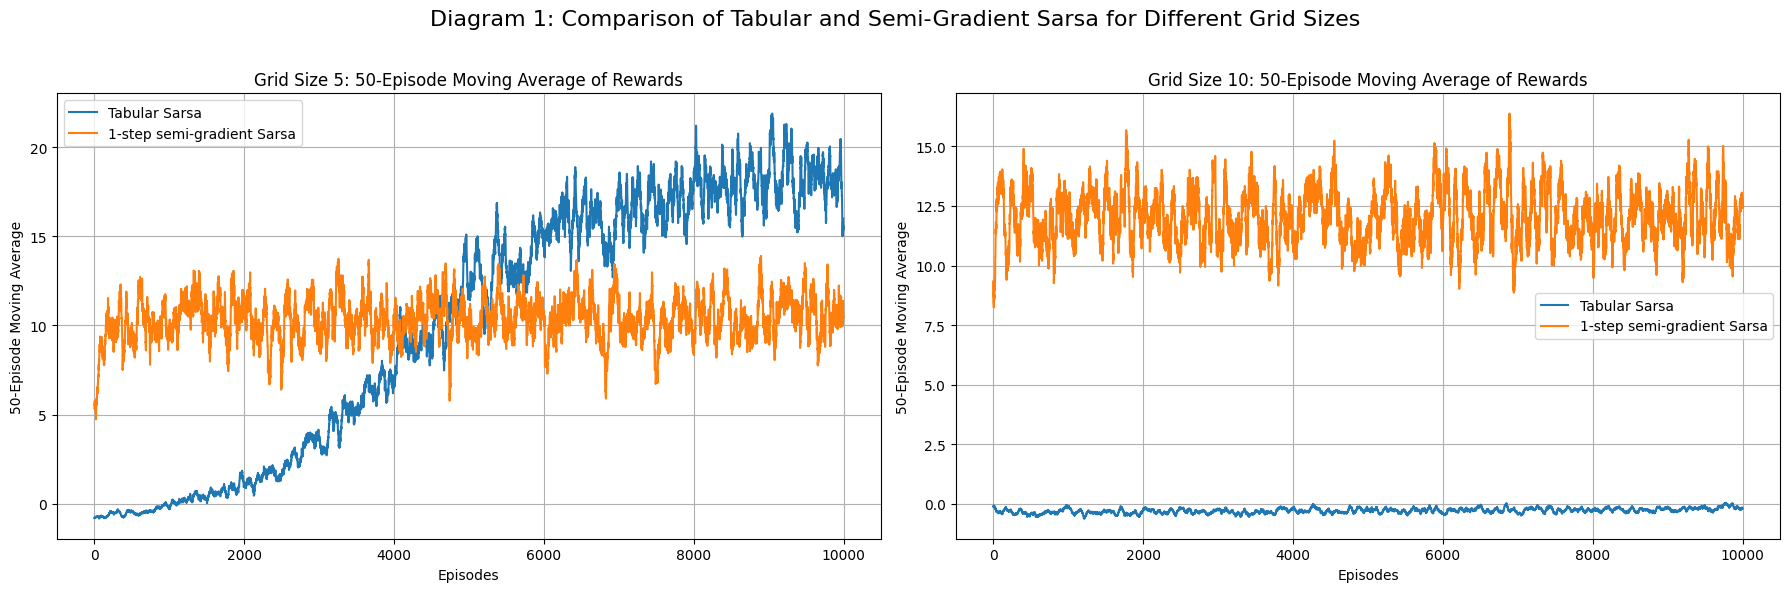

In [3]:
plot_comparison_grid(tabular_sarsa_5_episode_reward_storage, grad_sarsa5_episode_reward_storage,
                    tabular_sarsa_10_episode_reward_storage, grad_sarsa10_episode_reward_storage)

As can be seen from Diagram 1, the semi-gradient Sarsa method converges almost instantaneously, while the tabular approach takes longer time for the 5x5 grid size – but learns a more valuable policy.

For the 10x10 grid, however, the tabular Sarsa approach does not learn a valuable policy at all – it is still stuck in exploring mode.

This highlights how the approximation method takes a "shortcut" in learning, whereas the tabular approach becomes quite slow when the state space grows sufficiently large.

Now, let's compare the different gradient methods against eachother, using various levels of learning rate $\alpha$.

In [ ]:
# Set random seed for reproducibility
random.seed(900118)

# Run simulations and get results
results = run_all_simulations(num_episodes=5000, T=200)

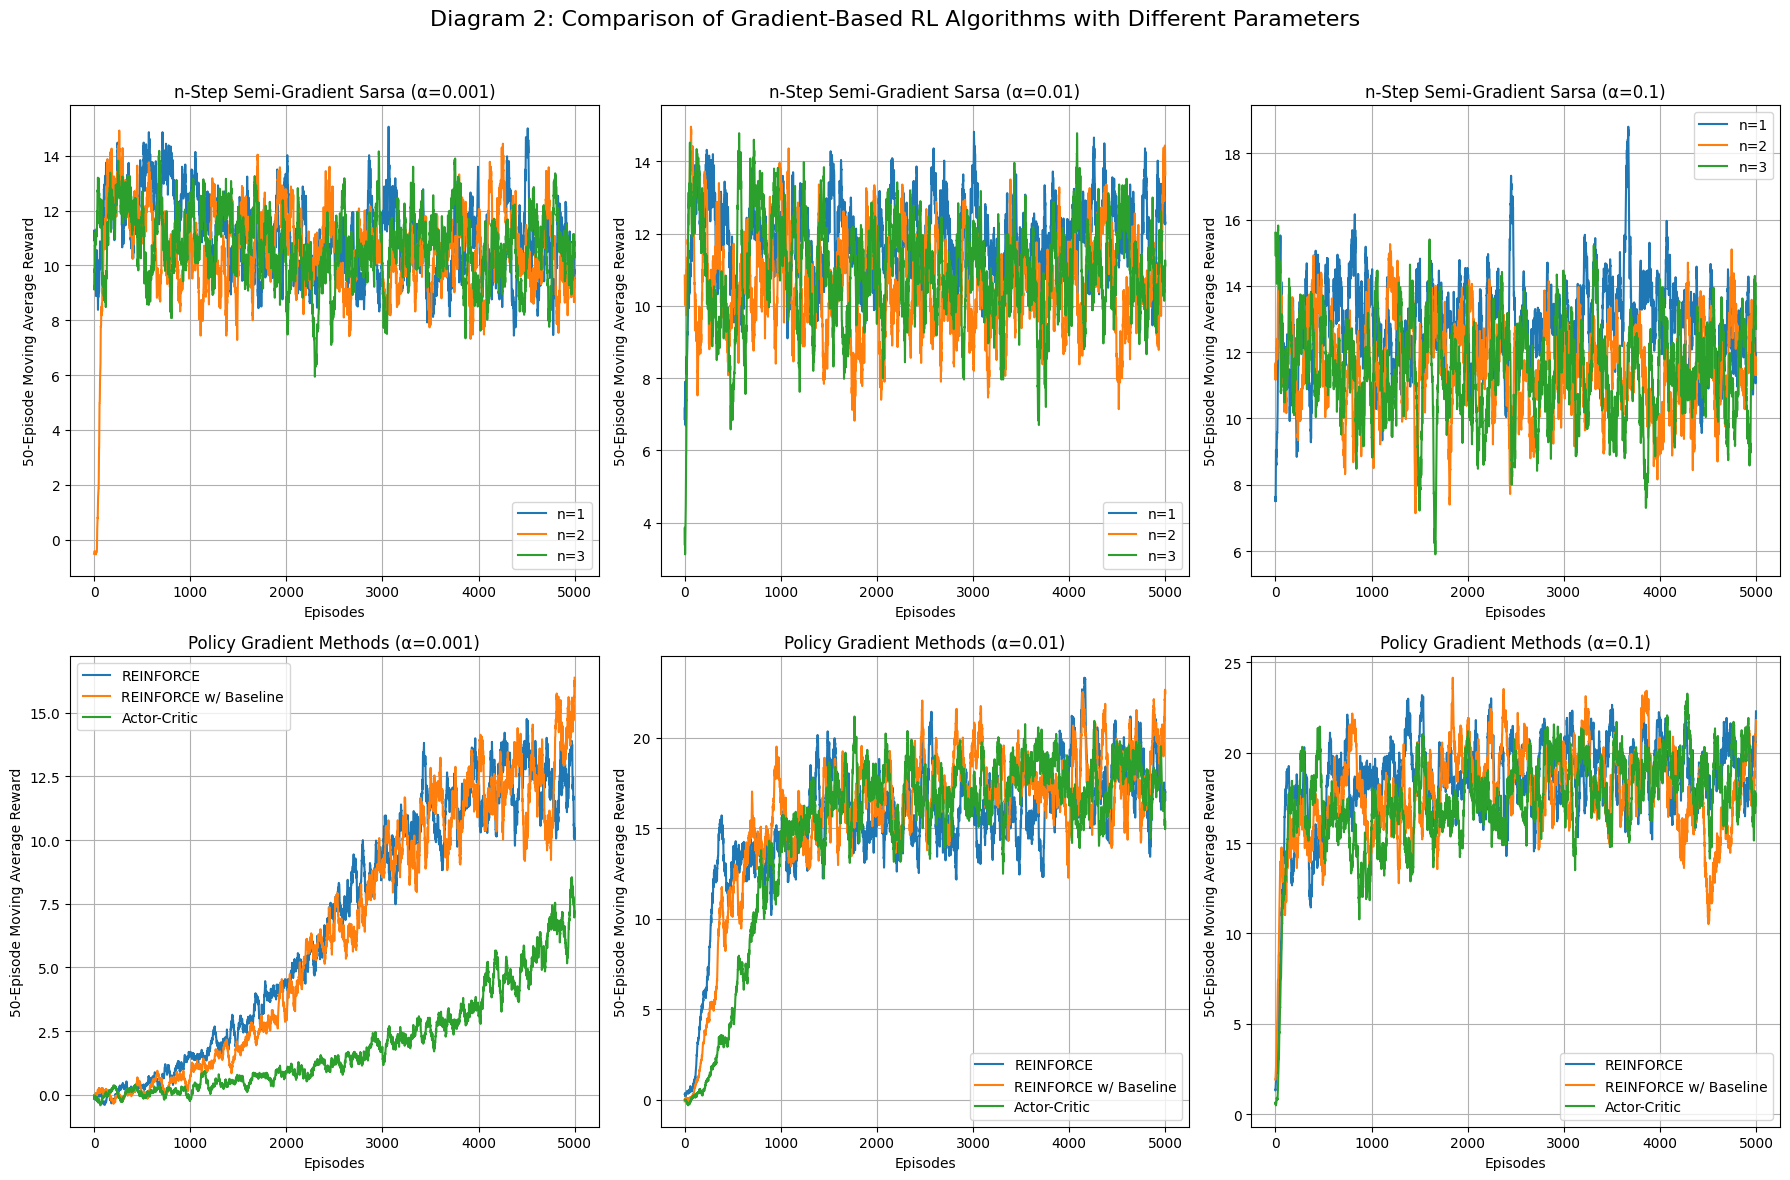

In [9]:
fig, results = plot_results(results)

As can be seen in Diagram 2, the n-step semi-gradient Sarsa methods are quite comparable to eachother, and all converge almost instantly for all values of $\alpha$.

As for the policy gradient methods, there is only a very small difference between REINFORCE and REINFORCE with baseline. The actor-critic method, however, converges much more slowly than the former, especially for low $\alpha$ values.

In general, the value gradient Sarsa method converges much more quickly than the policy gradient methods. However, the policy gradient methods seem to learn a more valuable policy than the former. Let's have a look at the mean reward and variance of the rewards for the methods, computed over all 5000 episodes.

In [10]:
# Example usage:
# Assuming 'results' is the dictionary returned from run_all_simulations()
performance_table = create_performance_table(results)
display(performance_table)

Noted from Table 1 is that the Sarsa methods only differ very slightly between the different $n$-settings, and also differ quite slightly for varying $\alpha$.

For the policy gradient methods, the REINFORCE and REINFORCE with baseline lie close to eachother in terms of both mean reward and variance. Notably, the mean reward increases significantly with higher $\alpha$, and so does the variance.

This is even more true for the actor-critic approach, which performs the very worst of all methods in terms of learning a valuable policy for low $\alpha$ settings, but learns equivalently to the other methods for the high $\alpha = 0.1$.

Now, let's look at how the different method has learned the weights, focusing on the policy weights in Table 2.

In [11]:
# Example usage:
# Assuming 'results' is the dictionary returned from run_all_simulations()
weights_table = create_weights_table(results)
display(weights_table)

,Weight 1: Inverse distance to apple,Weight 2: Inverse distance to monster,Weight 3: Moving closer to apple,Weight 4: Moving closer to monster
1-Step Semi-Gradient Sarsa,3.686,0.075,0.427,-0.109
2-Step Semi-Gradient Sarsa,3.622,0.649,0.798,-0.371
3-Step Semi-Gradient Sarsa,3.768,0.985,0.533,-0.056
REINFORCE,0,0,12.255,-5.695
REINFORCE with Baseline (Policy),0,0,9.006,-2.646
REINFORCE with Baseline (Value),1.142,-0.91,-0.289,-1.33
Actor-Critic (Policy),-0,-0,9.23,-2.311
Actor-Critic (Value),2.657,-1.221,1.589,-0.838


Most of the methods have learned to avoid the monster, reflected by the negative value of this feature. It is notable that the policy weights do not at all place any weight at the distances, but only on the action of the agent – which is more closely tied to the policy.

**How does the learning rate α affect the learning speed and convergence of the methods?**

Increased $\alpha$ in general increases the learning speed in this setting. However, a too high $\alpha$ will make the weights "explode" and become unreasonably big.

As for the semi-gradient Sarsa approach, only small differences are noted across the values of $\alpha$ tried here - the algorithm converges almost instantaneously for all values.

**How do the methods above compare in terms of convergence speed?**

The Sarsa methods converge very fast, but learn a slightly less valuable policy as compared to the policy gradient methods. Among the policy gradient methods, the actor-critic approach is the slowest. REINFORCE and REINFORCE w/ baseline performs quite similarly.

**In this example, does policy gradient methods perform better than the value-based methods? Why or why not?**

That depends on what we mean by "better". They learn a more valuable policy, but does so more slowly than the value-based approach in Sarsa.

Just as in tabular methods, value iteration may be considered a shortened version of policy iteration. It is possible that the policy gradient methods therefore take a bit longer to converge.